In [1]:
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm
from DS_Planck_Unet import *
from DS_healpix_fragmentation import one_pixel_fragmentation, matr2dict, radec2pix

In [11]:
for i in range(48):
    
    matr = one_pixel_fragmentation(2, i, 10)
    _, cl_df = pixels_with_clusters('/home/rt2122/Data/clusters/planck_z.csv', i, 256, 
                                 min_rad = 2.0)
    pic, mask = draw_pic_with_mask(None, 
                        clusters_arr=np.stack([cl_df['RA'], cl_df['DEC']]).T, 
                        matr=matr)
    cur_dir = os.path.join('/home/rt2122/Data/Planck/pregen/', str(i))
    os.mkdir(cur_dir)
    np.save(os.path.join(cur_dir, 'pic'), pic)
    np.save(os.path.join(cur_dir, 'mask'), mask)

In [4]:
a = set([(1, 2), (1, 3), (1, 2)])
a

{(1, 2), (1, 3)}

In [5]:
90000/4

22500.0

In [102]:
def gen_data_in_one_pix(ipix, n_patches, clusters, idx, size=64, 
                        outpath='/home/rt2122/Data/Planck/train/', 
                        inpath='/home/rt2122/Data/Planck/pregen/'):
    matr = one_pixel_fragmentation(2, ipix, 10)
    mdict = matr2dict(matr) 
    all_pixels = set()

    df = pd.read_csv(clusters)
    cl_pix = radec2pix(df['RA'], df['DEC'], nside=2048)
    cl_pix = [mdict[pix] for pix in cl_pix if pix in mdict]
    for pix in cl_pix:
        x_cl, y_cl = pix
        all_pixels = all_pixels.union(set(
            [(x, y) for x in range(max(x_cl-size+1, 64), min(x_cl+1,matr.shape[0]-64)) 
                for y in range(max(y_cl-size+1, 64), min(y_cl+1,matr.shape[1]-64))]))
    rand_idx = None
    if n_patches >= len(all_pixels):
        rand_idx = np.arange(len(all_pixels))
    else:
        rand_idx = np.random.choice(np.arange(len(all_pixels)), n_patches, 
                                    replace=False)
    lu_corners = np.array(list(all_pixels))[rand_idx.astype(int)]
    pic = np.load(os.path.join(inpath, str(ipix), 'pic.npy'))
    mask = np.load(os.path.join(inpath, str(ipix), 'mask.npy'))
    
    for x, y in lu_corners:
        c_pic = pic[x:x+size,y:y+size,:]
        c_mask = mask[x:x+size,y:y+size,:]
        
        np.save(os.path.join(outpath, 'x', str(idx)), c_pic)
        np.save(os.path.join(outpath, 'y', str(idx)), c_mask)
        
        idx += 1
    return idx

In [59]:
gen_data_in_one_pix(0, 10, '/home/rt2122/Data/clusters/planck_z.csv',
                   outpath='/home/rt2122/Data/Planck/check_gen/', idx=0)

10

In [55]:
a = set([(1, 2), (6, 7)])
np.array(list(a)).shape

(2, 2)

In [119]:
n_patches = 90000 // 40
idx = 0
n_patches

2250

In [120]:
for pix in tqdm(train_pix):
    idx = gen_data_in_one_pix(pix, n_patches, 
        '/home/rt2122/Data/clusters/planck_z.csv', idx)

In [121]:
n_patches = 12000 // len(val_pix)
idx = 0
n_patches

4000

In [122]:
for pix in tqdm(val_pix):
    idx = gen_data_in_one_pix(pix, n_patches, 
        '/home/rt2122/Data/clusters/planck_z.csv', idx, 
        outpath='/home/rt2122/Data/Planck/val')

In [123]:
n_patches = 4000
idx = 0

In [124]:
for pix in tqdm(test_pix):
    idx = gen_data_in_one_pix(pix, n_patches, 
        '/home/rt2122/Data/clusters/planck_z.csv', idx, 
        outpath='/home/rt2122/Data/Planck/test')

In [87]:
def gen_data_from_pregen(path, batch_size):
    import os
    import numpy as np
    from tensorflow import convert_to_tensor
    
    n_pics = len(next(os.walk(os.path.join(path, 'x')))[-1])
    idx_sh = np.arange(n_pics)
    np.random.shuffle(idx_sh)
    for st in range(0, n_pics, batch_size):
        x = []
        y = []
        for idx in idx_sh[st:st+batch_size]:
            x.append(np.load(os.path.join(path, 'x', str(idx)) + '.npy'))
            y.append(np.load(os.path.join(path, 'y', str(idx)) + '.npy'))
        yield convert_to_tensor(np.stack(x)), convert_to_tensor(np.stack(y))

In [125]:
train_gen = gen_data_from_pregen('/home/rt2122/Data/Planck/train/', 1)

(1, 64, 64, 6) (1, 64, 64, 1)


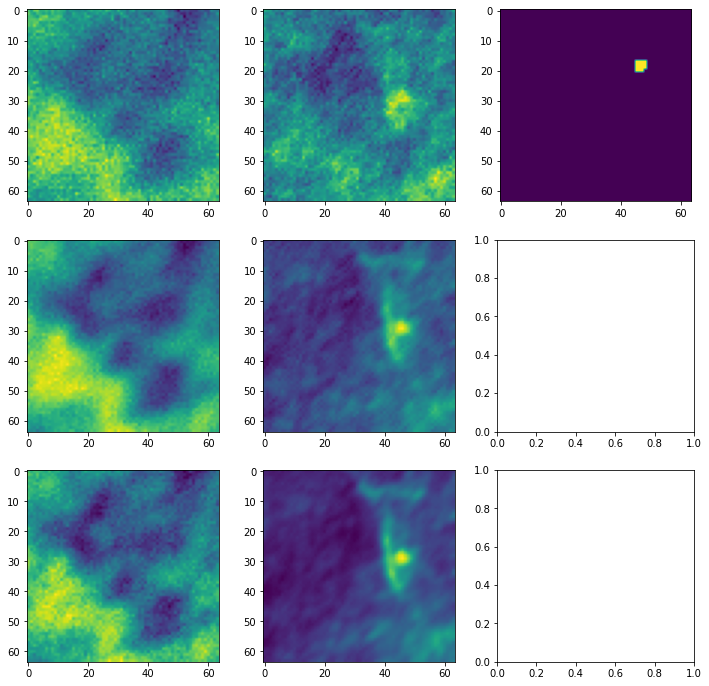

In [126]:
check_gen(train_gen)

In [127]:
for pic, mask in train_gen:
    if mask.shape[-1] > 1:
        print('#', end='')

In [2]:
print(len(next(os.walk('/home/rt2122/Data/Planck/train/x/'))[-1]))
print(len(next(os.walk('/home/rt2122/Data/Planck/val/x/'))[-1]))
print(len(next(os.walk('/home/rt2122/Data/Planck/test/x/'))[-1]))

97582
12000
4000


In [4]:
97582 / 20, 12000 / 20

(4879.1, 600.0)